In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.model_selection import train_test_split as sk_split

import numpy as np

In [219]:
### ignore these functions

In [210]:
# generic function to plot scores
def plot_CV_scores(score_train, score_test, index, index_label, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    ax.scatter(index, score_train, color='red', label='score_train')
    ax.plot(index, score_train, color='red')

    ax.scatter(index, score_test, color='blue', label='score_test')
    ax.plot(index, score_test, color='blue')

    ax.set_xlabel(index_label)
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend()

In [199]:
def cross_validation(x, y, param, method):
    y_cv = y
    x_cv = x
    
    n_param = len(param)
    score_train = np.zeros([n_param,5])
    score_valid = np.zeros([n_param,5])
    score_K = np.zeros([n_param,2])
    
    kf = KFold(len(y_cv),5, shuffle=True)
    
    j=0 #index the jth fold

    for train_idx, valid_idx in kf:

        # get training and validing sets 
        y_train, x_train = y_cv[train_idx, ], x_cv[train_idx, ]
        y_valid , x_valid  = y_cv[valid_idx, ], x_cv[valid_idx, ]


        # fit Lasso or Ridge regression with varying lambda
        for i in range(n_param):
            print i
            if method == 'logistic_l1':
                model = LogisticRegression(class_weight='balanced', penalty = 'l1', C = 10**param[i])
            elif method == 'logistic_l2':
                model = LogisticRegression(class_weight='balanced', penalty = 'l2', C = 10**param[i])
            elif method == 'svm':
                model = SVC(class_weight = 'balanced', C = 10**param[i])
                
          
            model.fit(x_train, y_train)
            score_train[i,j] = model.score(x_train, y_train)
            score_valid[i,j] = model.score(x_valid, y_valid)
        
        # calculate r-squared mean across five fold for each lamda
        for i in range(n_param):
            score_K[i,0]=score_train[i,:].mean()
            score_K[i,1]=score_valid[i,:].mean()

        j=j+1  
        
    plt.figure(figsize=(7.5,5))
    plt.plot(param,score_K[:,0],'ro-', label ='train set')          
    plt.plot(param,score_K[:,1],'bo-', label ='valid set')
    plt.title('Cross Validation for '+method);plt.xlabel('log(lambda)');plt.ylabel('R^2')
    plt.legend(loc = 'best')
    plt.savefig(method+'.png')

    plt.show()

In [144]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up: 
## ----------------
## main() will run code to extract features, learn, and make predictions.
## 
## extract_feats() is called by main(), and it will iterate through the 
## train/test directories and parse each xml file into an xml.etree.ElementTree, 
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn 
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to 
## their respective numeric values. 
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'. 
## Real-valued or count-based features can of course also be defined in this way. 
## Because this feature-function will be run over ElementTree objects for each 
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up 
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values 
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and 
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls 
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below 
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files 
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example. 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util


def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    i = 0
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
        
        i=+1
        if i%100 == 0: print i
        
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
        
    cols = []
    rows = []
    data = []        
    for i in xrange(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].iteritems():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict
    

## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

def all_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary containing all calls made by the program 
      and how many times they were called
    """
    all_calls = []
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            all_calls.append(el.tag)

    c = Counter(all_calls)
    return c

## The following function does the feature extraction, learning, and prediction
def main():
    train_dir = "train"
    test_dir = "test"
    outputfile = "mypredictions.csv"  # feel free to change this or take it as an argument
    
    # TODO put the names of the feature functions you've defined above in this list
    ffs = [first_last_system_call_feats, system_call_count_feats, all_count_feats]
    
    # extract features
    print "extracting training features..."
    X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
    print "done extracting training features"
    print
    
    # TODO train here, and learn your classification parameters
    print "learning..."
    model = RandomForest(class_weight = 'balanced', n_estimators=90, max_depth = 170)
    model.fit(X_train, t_train)
    print "done learning"
    print
    
    # get rid of training data and load test data
    del X_train
    del t_train
    del train_ids
    print "extracting test features..."
    X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
    print "done extracting test features"
    print
    
    # TODO make predictions on text data and write them out
    print "making predictions..."
    preds = model.predict(X_test)
    print "done making predictions"
    print
    
    print "writing predictions..."
    util.write_predictions(preds, test_ids, outputfile)
    print "done!"

In [145]:
if __name__ == "__main__":
    main()

extracting training features...
done extracting training features

learning...
done learning

extracting test features...
done extracting test features

making predictions...
done making predictions

writing predictions...
done!


### A new feature selection function to count all types of system calls.

In [ ]:
def all_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary containing all calls made by the program 
      and how many times they were called
    """
    all_calls = []
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            all_calls.append(el.tag)

    c = Counter(all_calls)
    return c

### Feature extraction and train-test split

In [214]:
# Extract features, including:
## first and last system call, 
## counts for all types of system call,
## total counts for system calls
train_dir = "train"
ffs = [first_last_system_call_feats, all_count_feats, system_call_count_feats]
X,global_feat_dict,t,train_ids = extract_feats(ffs, train_dir)
X_train, X_test, t_train, t_test = sk_split(X, t, test_size = 0.3)

In [216]:
# get class weights to use as priors
pClass = np.zeros((15,))
for i in range(15):
    pClass[i] = np.mean(t_train == i)
print pClass

[ 0.03472222  0.0162037   0.01481481  0.0087963   0.01388889  0.01296296
  0.01527778  0.01203704  0.5287037   0.00833333  0.17685185  0.00925926
  0.11712963  0.01805556  0.01296296]


### Try models

In [194]:
#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced', penalty = 'l1')
weighted_logistic.fit(X_train, t_train)

print 'weighted logistic'
print weighted_logistic.score(X_train, t_train), weighted_logistic.score(X_test, t_test)


#LDA
weighted_lda = LDA(priors = pClass)
weighted_lda.fit(X_train.toarray(), t_train)
print 'weighted lda'
print weighted_lda.score(X_train.toarray(), t_train), weighted_lda.score(X_test.toarray(), t_test)

#QDA
weighted_qda = QDA(priors = pClass)
weighted_qda.fit(X_train.toarray(), t_train)
print 'weighted qda'
print weighted_qda.score(X_train.toarray(), t_train), weighted_qda.score(X_test.toarray(), t_test)


#Decision Tree
weighted_tree = DecisionTree(class_weight = "balanced")
weighted_tree.fit(X_train, t_train)
print 'Decision Tree'
print weighted_tree.score(X_train, t_train), weighted_tree.score(X_test, t_test)



#Random Forest
weighted_rf = RandomForest(class_weight = 'balanced')
weighted_rf.fit(X_train, t_train)
print 'Random Forest'
print weighted_rf.score(X_train, t_train), weighted_rf.score(X_test, t_test)


# linearsvm
weighted_linearsvm= LinearSVC(class_weight = 'balanced')
weighted_linearsvm.fit(X_train, t_train)
print 'Weighted linearsvm'
print weighted_linearsvm.score(X_train, t_train), weighted_linearsvm.score(X_test, t_test)

weighted logistic
0.87962962963 0.814254859611
weighted lda
0.83287037037 0.788336933045
weighted qda
0.908796296296 0.81101511879
Decision Tree
0.981018518519 0.843412526998
Random Forest
0.975 0.873650107991
Weighted linearsvm
0.743055555556 0.704103671706


## Cross validation for Logistic regression with l1 and l2 penalty, SVM and Random Forest

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


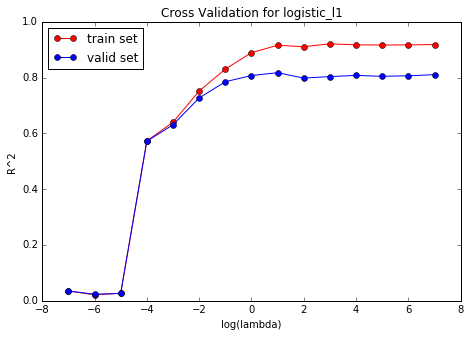

In [195]:
cross_validation(X_train, t_train, range(-7,8), 'logistic_l1')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


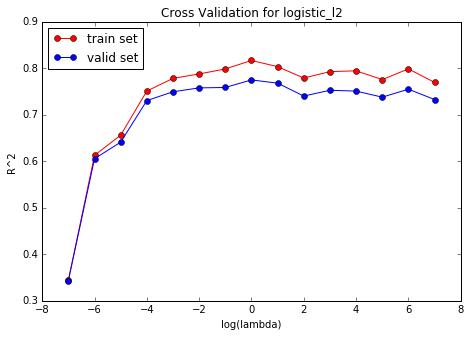

In [196]:
cross_validation(X_train, t_train, range(-7,8), 'logistic_l2')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


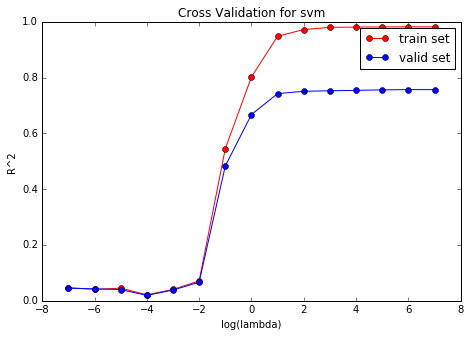

In [200]:
cross_validation(X_train, t_train, range(-7,8), 'svm')

In [206]:
# Generic function for cross-validation 
def AutoKFold_RF(train_x, train_y, params1, params2, params3):
    #Create a k-folds validation object
    kf = KFold(len(train_y), n_folds=5)
    #Record the mean score for each depth
    score_test = []
    score_train = []
    n = len(train_y)
    #print params1
    #Iterate over the parameters
    for param1 in params1:    
        for param2 in params2:
            for param3 in params3:
                #Record the score for each fold
                valid_score_test = []
                valid_score_train = []
                #print param1
                #Iterate over the folds
                for train_index, test_index in kf:
                    #Split x_train into a train and "test" set
                    x_validate_train, x_validate_test = train_x[train_index], train_x[test_index]
                    y_validate_train, y_validate_test = train_y[train_index], train_y[test_index]

                    model = RandomForest(n_estimators=param1, max_depth=param2, max_features=param3)

                    model.fit(x_validate_train, y_validate_train)

                    #Compute the scores
                    valid_score_test.append(model.score(x_validate_test, y_validate_test))
                    valid_score_train.append(model.score(x_validate_train, y_validate_train))
                #Append the mean scores over the k-folds to score list
                score_test.append(np.mean(valid_score_test))
                score_train.append(np.mean(valid_score_train))

                print ("Trees:", param1, "Max_depth:", param2, "Max_features:", param3,
                       "Testing score:", round(np.mean(valid_score_test), 4), 
                       "Training score:", round(np.mean(valid_score_train), 4))

    return(np.concatenate((score_test, score_train)))


In [207]:
n_trees = np.arange(50, 120, 30)  
depths = np.arange(10, 200, 10)
features = np.arange(10, 133, 10)
n_combos = len(n_trees)*len(depths)*len(features)
print 'Number of combos: ', n_combos
scores = AutoKFold_RF(X_train, t_train, n_trees, depths, features)
scores_test = scores[:n_combos]
scores_train = scores[n_combos:]

Number of combos:  741
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 10, 'Testing score:', 0.8787, 'Training score:', 0.9553)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 20, 'Testing score:', 0.8796, 'Training score:', 0.9606)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 30, 'Testing score:', 0.8792, 'Training score:', 0.9633)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 40, 'Testing score:', 0.8829, 'Training score:', 0.9646)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 50, 'Testing score:', 0.8894, 'Training score:', 0.9644)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 60, 'Testing score:', 0.8838, 'Training score:', 0.9645)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 70, 'Testing score:', 0.8861, 'Training score:', 0.965)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 80, 'Testing score:', 0.8852, 'Training score:', 0.9653)
('Trees:', 50, 'Max_depth:', 10, 'Max_features:', 90, 'Testing score:', 0.8829, 'Training score:', 0.9628)
('Trees:', 50, 

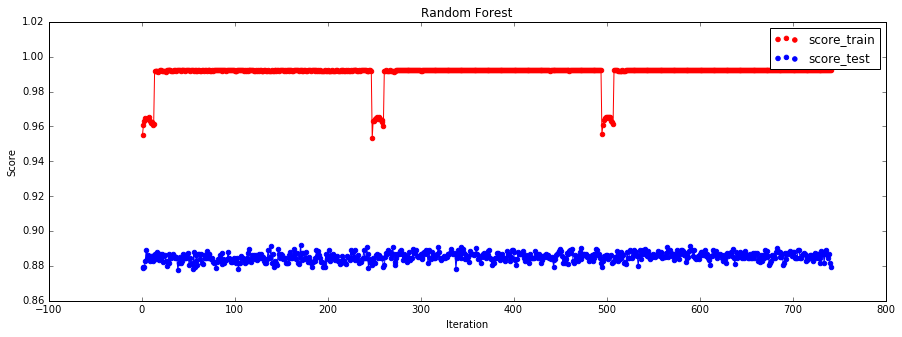

In [211]:
plot_CV_scores(scores_train, scores_test, range(1, n_combos+1), 'Iteration', 'Random Forest')

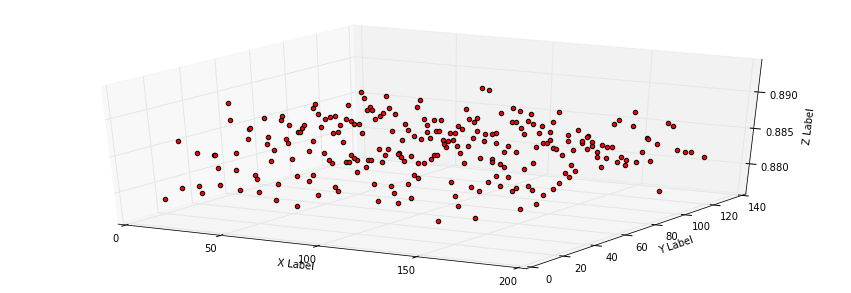

In [212]:
from mpl_toolkits.mplot3d import Axes3D

# plot 3D surface of max_depth vs. max_features vs. score 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')

i = 0
for d in depths:
    for f in features:
        ax.scatter(d, f, scores_test[i], c='r', marker='o')
        i = i + 1
#ax.scatter(depths, features, scores_test, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

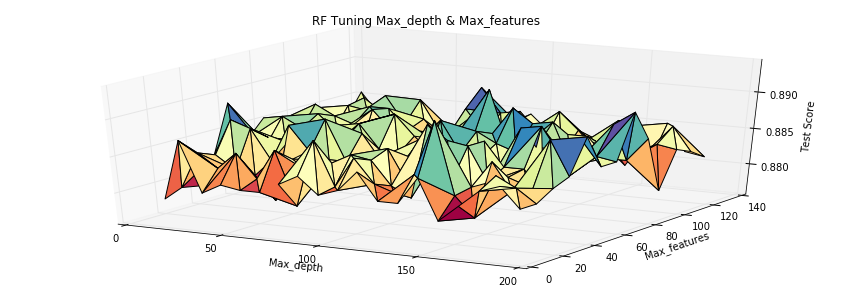

In [213]:
# plot 3D surface of max_depth vs. max_features vs. score 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')

num_points = len(depths)*len(features)

X = range(0, num_points)
Y = range(0, num_points)
Z = range(0, num_points)
i = 0
for d in depths:
    for f in features:
        X[i] = d
        Y[i] = f
        Z[i] = scores_test[i]
        #ax.scatter(d, f, scores_test[i], c='r', marker='o')
        i = i + 1
        
ax.plot_trisurf(X, Y, Z, cmap=plt.cm.Spectral)
ax.set_title('RF Tuning Max_depth & Max_features')
ax.set_xlabel('Max_depth')
ax.set_ylabel('Max_features')
ax.set_zlabel('Test Score')

plt.show()

# plot average scores given each max_depth, each max_feature

### Model comparison under best parameters

In [218]:
# Weighted logistic regression
weighted_logistic_L1 = LogisticRegression(class_weight='balanced', penalty = 'l1', C = 10)
weighted_logistic_L1.fit(X_train, t_train)
print 'weighted logistic L1'
print weighted_logistic_L1.score(X_train, t_train), weighted_logistic_L1.score(X_test, t_test)

weighted_logistic_L2 = LogisticRegression(class_weight='balanced', penalty = 'l2', C = 1)
weighted_logistic_L2.fit(X_train, t_train)
print 'weighted logistic L2'
print weighted_logistic_L2.score(X_train, t_train), weighted_logistic_L2.score(X_test, t_test)

# svm
weighted_svm= SVC(class_weight = 'balanced', C = 100)
weighted_svm.fit(X_train, t_train)
print 'Weighted svm'
print weighted_svm.score(X_train, t_train), weighted_svm.score(X_test, t_test)

# Random Forest
weighted_rf = RandomForest(class_weight = 'balanced', n_estimators= 110, max_features= 100, max_depth=100)
weighted_rf.fit(X_train, t_train)
print 'Random Forest'
print weighted_rf.score(X_train, t_train), weighted_rf.score(X_test, t_test)

#LDA
weighted_lda = LDA(priors = pClass)
weighted_lda.fit(X_train.toarray(), t_train)
print 'weighted lda'
print weighted_lda.score(X_train.toarray(), t_train), weighted_lda.score(X_test.toarray(), t_test)

#QDA
weighted_qda = QDA(priors = pClass)
weighted_qda.fit(X_train.toarray(), t_train)
print 'weighted qda'
print weighted_qda.score(X_train.toarray(), t_train), weighted_qda.score(X_test.toarray(), t_test)

weighted logistic L1
0.909259259259 0.82505399568
weighted logistic L2
0.715740740741 0.666306695464
Weighted svm
0.969444444444 0.774298056156
Random Forest
0.979166666667 0.870410367171
weighted lda
0.836574074074 0.789416846652
weighted qda
0.929166666667 0.817494600432
